### Libraries

In [1]:
from timeit import timeit
from tkinter import NE
import pandas as pd
import pytest
import multiprocessing 
import numpy as np
from multiprocessing import Pool
import random
from functools import reduce
import time
import geopandas as gpd
from shapely.geometry import Point, Polygon
from sentinelhub import *
import os
import json
from functools import wraps
import sys
import os
import dask.dataframe as dd
import threading
import psutil
import matplotlib.pyplot as plt
import subprocess
#from sask_ndti_analysis.src.data.make_dataset import data## dummy dataframe

In [2]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/src/data")

In [3]:
import make_dataset
from make_dataset import data,dd_df

Let us first define the list of functions we will be using to justify the method of parallelization we would be using. The methods for parallelization that we will be using are: 1) Multiprocessing 2)Threading Pre-emptive 3) Threading Asyncio

### Functions

In [4]:
def if_prime(x):
    if x <= 1:
        return 0
    elif x <= 3:
        return x
    elif x % 2 == 0 or x % 3 == 0:
        return 0
    i = 5
    while i**2 <= x:
        if x % i == 0 or x % (i + 2) == 0:
            return 0
        i += 6
    return x

def df_func(df):
    value=df["PSECT"]*df["PMER"]
    value=round(value,ndigits=None)
    value=value.apply(func=if_prime)
    return value.sum()

def df_func_fib(df):
    value=df["PSECT"]*df["PMER"]
    value=round(value,ndigits=None)
    value=value.apply(func=fib)
    return value.sum()

def df_multiply(df):
    value=df["PSECT"]*df["PMER"]
    return value

def fib(n):
    if n <= 2: 
        return 1
    else: 
        return fib(n-1) + fib(n-2)

## Experimentation (AB\m Testing)

### Problem Statement

The problem statement is clear: We want to test which type of method performes best in terms CPU, Wall Time and memory usage. The methods are as follows: 1) No Parallelization(Iterative Method) 2. Multiprocessing 3. Threading(Asynchio) 4. Threading(Pre-Emptive) 5. Subprocess 6. Concurrent Futures

### Planning

We are using summation of prime function as a benchmark to reach the conclusion of our experimentation.These are the steps that we will be using to reach our conclusion. 
1. Plots of CPU time, Wall time will be plotted and shown for all methods used.
2. Memory usage will be shown for all the methods
3. What is the cpu usage during these methods(done in terminal through htop)?

Now, we understand that there may be potential of bottlenecks so we shall explore why that may be happening

### Data
The dataframe we are using, contains two randomized normal variables of 10000000 rows. In our function, we multiply these two columns and sum the primes in this formed series.

### Analysis(CPU, Wall Time and memory usage)

For each of the methods, we outlined in the problem statement, let us see how they perform and plot the results.

#### Iterative

In [147]:
%%time
it_start_wall_two_core=time.perf_counter()
it_start_cpu_two_core=time.process_time()
iterative_prime_value=df_func(data)
print(iterative_prime_value)
it_end_wall_two_core=time.perf_counter()
it_end_cpu_two_core=time.process_time()
print("CPU TIME: ",it_end_cpu_two_core-it_start_cpu_two_core)

1719917227.0
CPU TIME:  12.235491600000046
CPU times: user 11.5 s, sys: 726 ms, total: 12.2 s
Wall time: 12.3 s


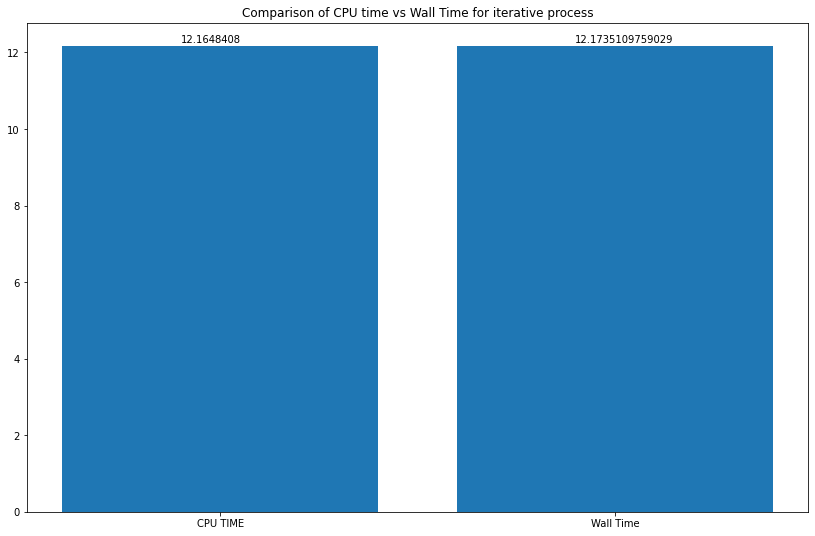

In [30]:
it_cpu_time=it_end_cpu_two_core-it_start_cpu_two_core
it_wall_time= it_end_wall_two_core-it_start_wall_two_core
x_val=["CPU TIME","Wall Time"]
y=[it_cpu_time,it_wall_time]
fig, ax = plt.subplots(figsize =(14, 9))
plt.bar(height=y,x=x_val)
ax.set_title("Comparison of CPU time vs Wall Time for iterative process")
plt.text(-0.1, y[0]+0.1, str(y[0]))
plt.text(0.9, y[1]+0.1, str(y[1]))
plt.show()


As you can see the CPU and Wall time are pretty similar.
Let us look at the line by line CPU and memory usage of this function.

In [8]:
%load_ext line_profiler

In [9]:
%lprun -f df_func df_func(data)

Timer unit: 1e-06 s

Total time: 23.4425 s
File: /tmp/ipykernel_1505457/865498790.py
Function: df_func at line 15

Line #      Hits         Time  Per Hit   % Time  Line Contents
    15                                           def df_func(df):
    16         1      41944.0  41944.0      0.2      value=df["PSECT"]*df["PMER"]
    17         1      35041.0  35041.0      0.1      value=round(value,ndigits=None)
    18         1   23334898.0 23334898.0     99.5      value=value.apply(func=if_prime)
    19         1      30598.0  30598.0      0.1      return value.sum()

As you can see, most of the cpu usage is from the apply function where we pass every value to the if_prime function. Let us look at the memory usage now.

In [8]:
%load_ext memory_profiler

In [9]:
%memit df_func(data)

peak memory: 1759.71 MiB, increment: 919.59 MiB


The peak memory usage was close to 2 Gb and the increment due to this function was around 920 Mb

#### Multiprocessing

Let us start by looking at some cpu and memory configurations of Virtual Machine

In [10]:
import threading 
print("Number of Active Threads:", threading.active_count())
print("Number of Physical Cores:", psutil.cpu_count(logical=False))
print("Number of logical Cores: ", psutil.cpu_count())
print("CPU frequency: ", psutil.cpu_freq())

Number of Active Threads: 7
Number of Physical Cores: 1
Number of logical Cores:  2
CPU frequency:  scpufreq(current=2593.907, min=0.0, max=0.0)


In [12]:
print("Total Memory in GB:", psutil.virtual_memory().total / 1e9 )
print("Free Memory in GB: " ,psutil.virtual_memory().free / 1e9 )
psutil.Process()

Total Memory in GB: 8.340148224
Free Memory in GB:  2.08422912


psutil.Process(pid=1505457, name='python', status='running', started='17:29:01')

This is the function that will make the multiprocessing work where we will first split the dataframe into 1000 parts and apply our function parallely to these 1000 parts. At the end, we will join our results

In [5]:
def get_data(df,func,n_split=1000,n_core=2):
    df_split=np.array_split(df,n_split)
    pool=Pool(n_core)
    df=sum(pool.map(func,df_split))
    pool.close()
    pool.join()
    return df

#### Try to experiment the pool map, what is the optimal split, optimization problem
#### hybercube sampling, lattice sampling
#### calculate carbon in soil, no tilt agriculture(make money because of carbon storage)
#### metamorals

Since we have two logical cores, let us test how the wall and cpu times vary by core and split and find out the best parameters

In [63]:
n_cores=[1,2]
split=[1,2,10,100,1000,10000]
result_cpu=[]
result_wall=[]
for n in n_cores:
    for j in split:
        mult_start_wall_two_core=time.perf_counter()
        mult_start_cpu_two_core=time.process_time()
        multiproc_mult_df=get_data(data,func=df_func,n_split=j,n_core=n)
        mult_end_wall_two_core=time.perf_counter()
        mult_end_cpu_two_core=time.process_time()
        print('>Walltime cores=%d: split %s %.3f seconds' % (n,j, mult_end_wall_two_core-mult_start_wall_two_core))
        print('>CPUtime cores=%d: split %s %.3f seconds' % (n,j, mult_end_cpu_two_core-mult_start_cpu_two_core))
        result_wall.append(mult_end_wall_two_core-mult_start_wall_two_core)
        result_cpu.append(mult_end_cpu_two_core-mult_start_cpu_two_core)

>Walltime cores=1: split 1 12.531 seconds
>CPUtime cores=1: split 1 0.414 seconds
>Walltime cores=1: split 2 12.295 seconds
>CPUtime cores=1: split 2 0.445 seconds
>Walltime cores=1: split 10 12.395 seconds
>CPUtime cores=1: split 10 0.468 seconds
>Walltime cores=1: split 100 12.207 seconds
>CPUtime cores=1: split 100 0.508 seconds
>Walltime cores=1: split 1000 13.143 seconds
>CPUtime cores=1: split 1000 0.639 seconds
>Walltime cores=1: split 10000 20.129 seconds
>CPUtime cores=1: split 10000 1.949 seconds
>Walltime cores=2: split 1 12.693 seconds
>CPUtime cores=2: split 1 0.420 seconds
>Walltime cores=2: split 2 11.065 seconds
>CPUtime cores=2: split 2 0.431 seconds
>Walltime cores=2: split 10 11.230 seconds
>CPUtime cores=2: split 10 0.578 seconds
>Walltime cores=2: split 100 10.968 seconds
>CPUtime cores=2: split 100 0.534 seconds
>Walltime cores=2: split 1000 11.408 seconds
>CPUtime cores=2: split 1000 0.687 seconds
>Walltime cores=2: split 10000 16.907 seconds
>CPUtime cores=2: sp

In [100]:
min_cpu_time=min(result_cpu)
min_index_cpu=result_cpu.index(min_cpu_time)
print("core: {} , split is {}".format((min_index_cpu//6)+1,split[min_index_cpu%6]))

core: 1 , split is 1


In [102]:
min_wall_time=min(result_wall)
min_index_result=result_wall.index(min_wall_time)
print("core: {} , split is {}".format((min_index_result//6)+1,split[min_index_result%6]))

core: 2 , split is 100


In [115]:
from operator import add
total_time=list( map(add, result_wall,result_cpu) )
index=total_time.index(min(total_time))
print("core: {} , split is {}".format((index//6)+1,split[index%6]))

core: 2 , split is 2


In terms of total time, core 2 and split 2 performed the best. Let us plot the results

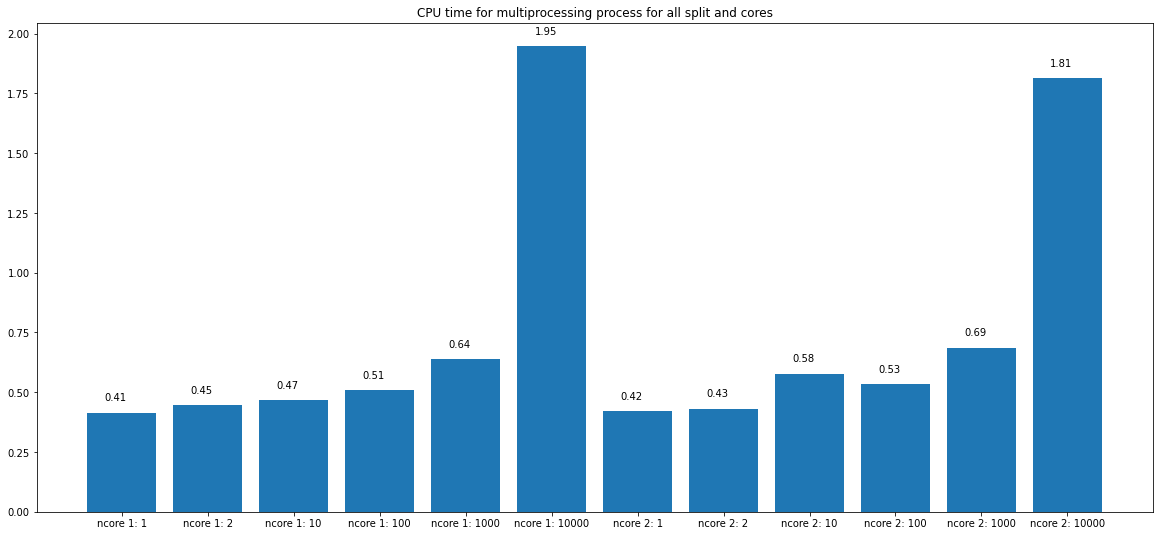

In [135]:
total=len(n_cores)*len(split)
x_val=[]
for values in split:
    x="ncore 1: " + str(values)
    x_val.append(x)

for values in split:
    x="ncore 2: " + str(values)
    x_val.append(x)

fig, ax = plt.subplots(figsize =(20, 9))
plt.bar(height=result_cpu,x=x_val)
ax.set_title("CPU time for multiprocessing process for all split and cores")
i=0
for values in range(1,13):
    plt.text(-0.2 + 1*(values-1), result_cpu[values-1]+0.05,str(round(result_cpu[values-1],2)))
    i=i+1
#plt.text(0.9, y[1]+0.1, str(y[1]))
plt.show()

In terms of cpu time, ncore 1 and split 1 performed best however ncore 2, split 1 and ncore 2, split 2 performed similarly as well

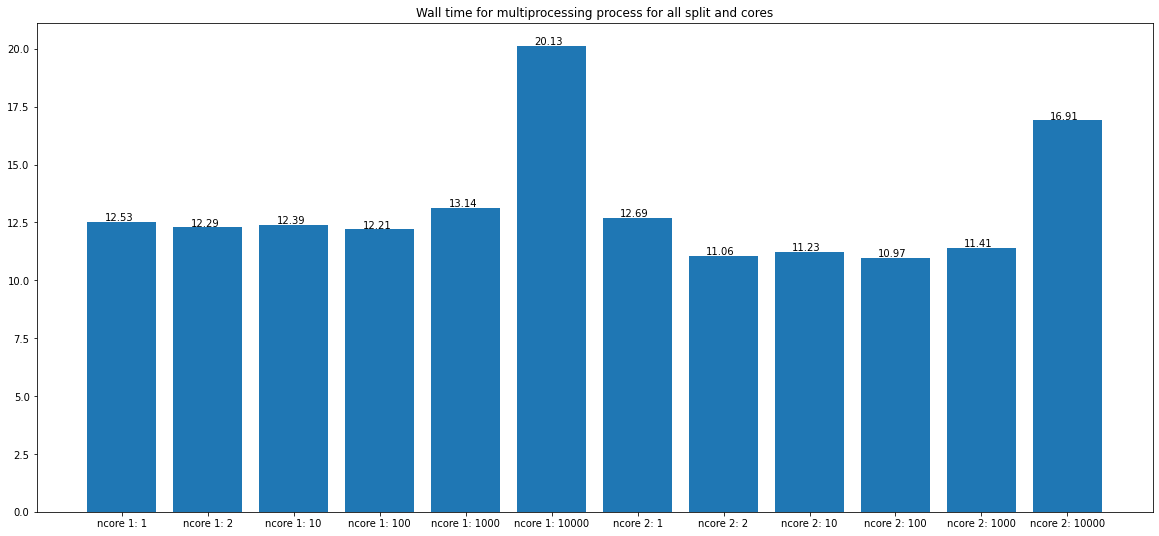

In [136]:
total=len(n_cores)*len(split)
x_val=[]
for values in split:
    x="ncore 1: " + str(values)
    x_val.append(x)

for values in split:
    x="ncore 2: " + str(values)
    x_val.append(x)

fig, ax = plt.subplots(figsize =(20, 9))
plt.bar(height=result_wall,x=x_val)
ax.set_title("Wall time for multiprocessing process for all split and cores")
i=0
for values in range(1,13):
    plt.text(-0.2 + 1*(values-1), result_wall[values-1]+0.05,str(round(result_wall[values-1],2)))
    i=i+1
#plt.text(0.9, y[1]+0.1, str(y[1]))
plt.show()

In terms of wall time, ncore 2, split 100 performed best however ncore 2, split 2 was close

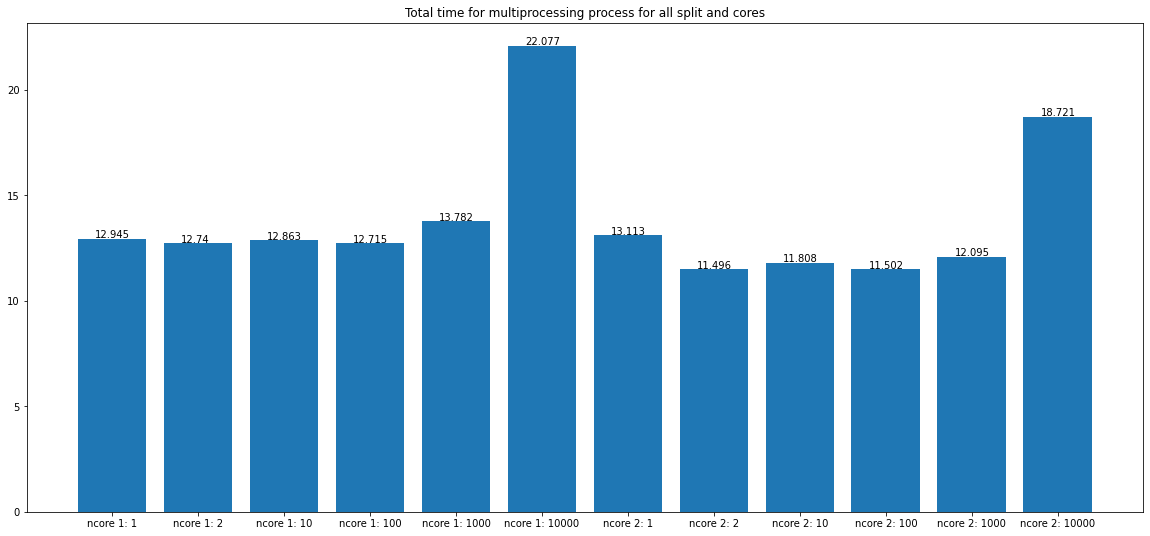

In [139]:
total=len(n_cores)*len(split)
x_val=[]
for values in split:
    x="ncore 1: " + str(values)
    x_val.append(x)

for values in split:
    x="ncore 2: " + str(values)
    x_val.append(x)

fig, ax = plt.subplots(figsize =(20, 9))
plt.bar(height=total_time,x=x_val)
ax.set_title("Total time for multiprocessing process for all split and cores")
i=0
for values in range(1,13):
    plt.text(-0.2 + 1*(values-1), total_time[values-1]+0.05,str(round(total_time[values-1],3)))
    i=i+1
plt.show()

Overally, we can conclude that ncore 2,split 2 performed the best since it has the lowest total time. So let us investigate this special case in details i.e find out how cpu core changes performance and the memory usage of the function.

In [6]:
n_cores=[1,2]
result_cpu=[]
result_wall=[]
for n in n_cores:
    mult_start_wall_two_core=time.perf_counter()
    mult_start_cpu_two_core=time.process_time()
    multiproc_mult_df=get_data(data,df_func,n_split=2,n_core=n)
    mult_end_wall_two_core=time.perf_counter()
    mult_end_cpu_two_core=time.process_time()
    print('>Walltime cores=%d: %.3f seconds' % (n, mult_end_wall_two_core-mult_start_wall_two_core))
    print('>CPUtime cores=%d: %.3f seconds' % (n, mult_end_cpu_two_core-mult_start_cpu_two_core))
    result_wall.append(mult_end_wall_two_core-mult_start_wall_two_core)
    result_cpu.append(mult_end_cpu_two_core-mult_start_cpu_two_core)


>Walltime cores=1: 12.665 seconds
>CPUtime cores=1: 0.462 seconds
>Walltime cores=2: 11.296 seconds
>CPUtime cores=2: 0.452 seconds


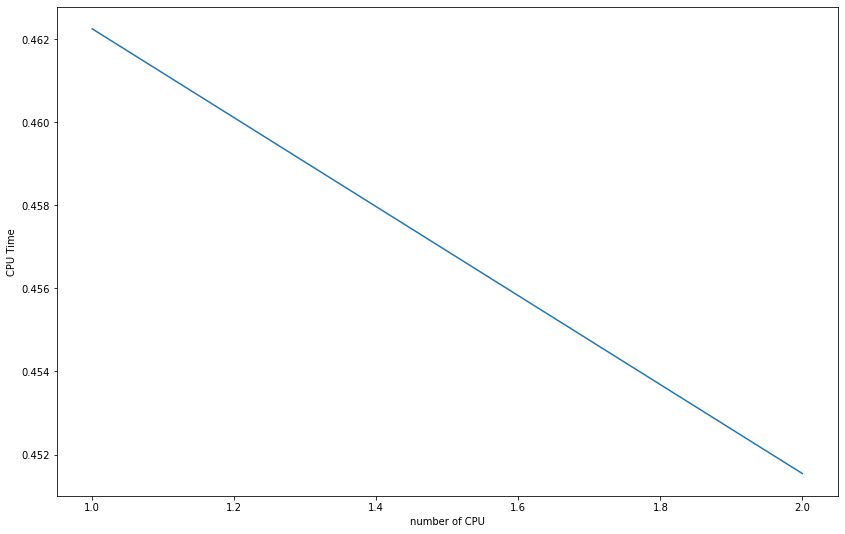

In [7]:
fig, ax = plt.subplots(figsize =(14, 9))
plt.plot(n_cores,result_cpu)
plt.xlabel("number of CPU")
plt.ylabel("CPU Time")
plt.show()

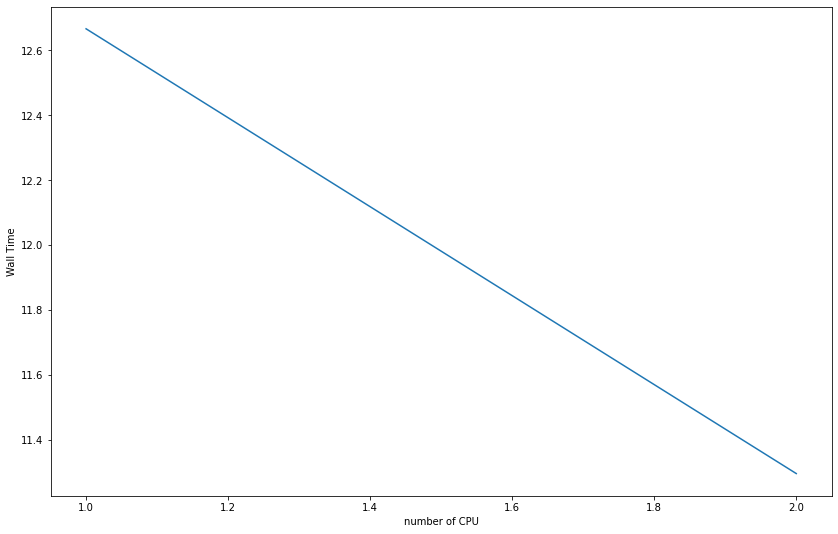

In [8]:
fig, ax = plt.subplots(figsize =(14, 9))
plt.plot(n_cores,result_wall)
plt.xlabel("number of CPU")
plt.ylabel("Wall Time")
plt.show()

Cpu times were extremely close however there was a significant difference in Wall Time. Let us now look at the memory usage from both cores.

In [9]:
%load_ext memory_profiler

In [10]:
%memit get_data(data,df_func,n_split=2,n_core=2)

peak memory: 1068.07 MiB, increment: 228.95 MiB


The peak memory is 1068 Mib and memory usage by the function was only 228 Mb in the 2 core method. This is significantly lower than the iterative process as much as 4 times.

In [11]:
%memit get_data(data,df_func,n_split=2,n_core=1)

peak memory: 1068.25 MiB, increment: 228.90 MiB


The peak memory is little bit lower but fairly similar to the 2 core method. Now, let us move to see the cpu usage which will be done in terminal htop user

In the terminal, we see that both of our cpus are at 100% capacity.

One suprising thing we noticed with the multiprocessing method is that CPU time is extremely low. Let us compare it with the iterative process

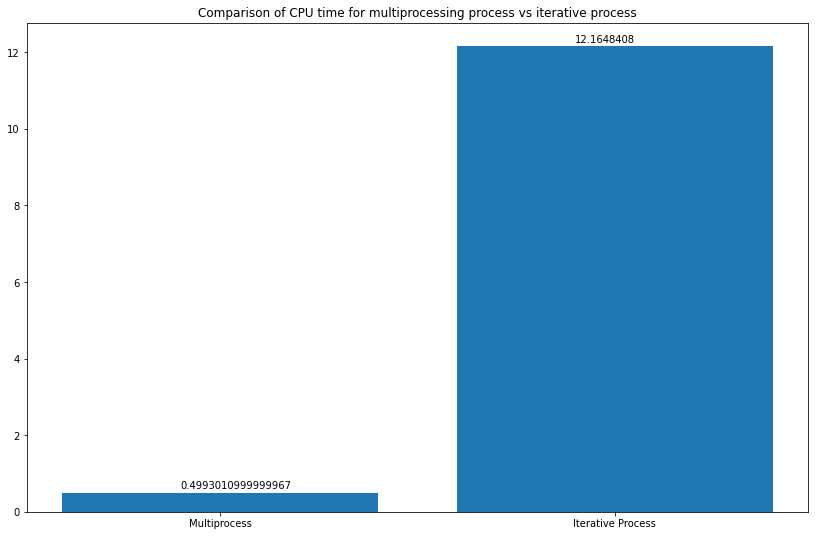

In [31]:
mult_cpu_time=result_cpu[1]
x_val=["Multiprocess","Iterative Process"]
y=[mult_cpu_time,it_cpu_time]
fig, ax = plt.subplots(figsize =(14, 9))
plt.bar(height=y,x=x_val)
ax.set_title("Comparison of CPU time for multiprocessing process vs iterative process")
plt.text(-0.1, y[0]+0.1, str(y[0]))
plt.text(0.9, y[1]+0.1, str(y[1]))
plt.show()

As you can see, it is significantly lower than the iterative process in the case of two cores. Now, let us compare to the wall time

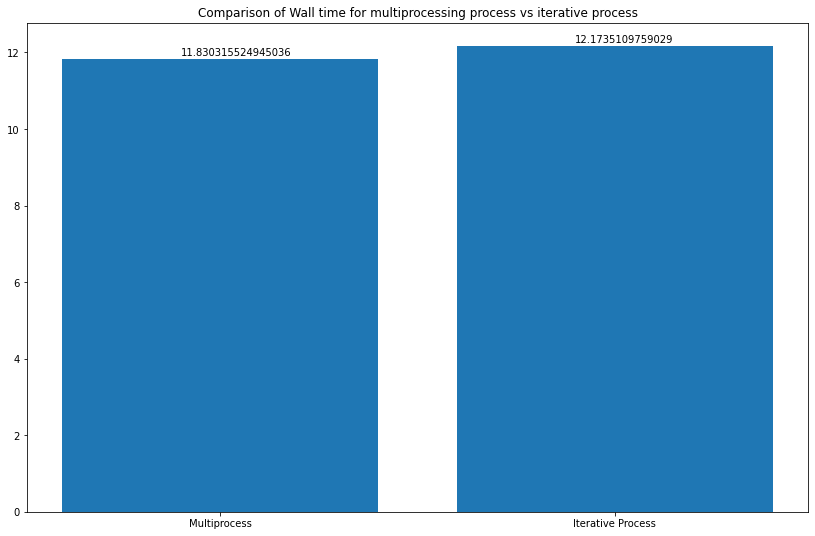

In [33]:
x_val=["Multiprocess","Iterative Process"]
y=[result_wall[1],it_wall_time]
fig, ax = plt.subplots(figsize =(14, 9))
plt.bar(height=y,x=x_val)
ax.set_title("Comparison of Wall time for multiprocessing process vs iterative process")
plt.text(-0.1, y[0]+0.1, str(y[0]))
plt.text(0.9, y[1]+0.1, str(y[1]))
plt.show()

The Wall time is a little bit shorter and it is interesting to see even though CPU time is so short, wall time is high. This might be due to bottleneck which we will explore later.

In [18]:
%load_ext line_profiler

In [19]:
%lprun -f get_data get_data(data,df_func)

Timer unit: 1e-06 s

Total time: 23.6352 s
File: /tmp/ipykernel_1413811/4149737121.py
Function: get_data at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def get_data(df,func,n_split=1000,n_core=2):
     2         1     329988.0 329988.0      1.4      df_split=np.array_split(df,n_split)
     3         1      28360.0  28360.0      0.1      pool=Pool(n_core)
     4         1   23260029.0 23260029.0     98.4      df=sum(pool.map(func,df_split))
     5         1        114.0    114.0      0.0      pool.close()
     6         1      16705.0  16705.0      0.1      pool.join()
     7         1          3.0      3.0      0.0      return df

The cpu usage is checked by the command htop user command in the terminal and it can be seen during the multiprocessing that both the logical cores of the cpu are at 100%.

In [21]:
## why is that a bottleneck? where is the difference? perf_counter, number of task(in parallel), time taken(wall time), cpu time, memory time, 
## perf_counter,  at any time(how many tasks each cpu core); assuming they are running at the same time, how many tasks are they completing at any given time?
## split the 
## other competitors of dask
## think academically and like a scientist
## hypothesis testing

Let us now try for threading to see how it performs.

#### Threading(Asyncio)

Earlier we saw that we had 7 active threads so let us test how they perform in terms CPU and wall time

In [11]:
def thread_par(df,n,func):
    pool=ThreadPool(processes=n)
    async_result=pool.apply_async(func,args=(df,))
    return_val=async_result.get()
    return return_val

In [12]:
from multiprocessing.pool import ThreadPool
threads=list(range(1,8))
result_cpu=[]
result_wall=[]
for n in threads:
    thre_start_wall=time.perf_counter()
    thre_start_cpu=time.process_time()
    return_val=thread_par(data,n=n,func=df_func)
    print(return_val)
    thre_end_wall=time.perf_counter()
    thre_end_cpu=time.process_time()
    print('>Walltime thread=%d: %.3f seconds' % (n, thre_end_wall-thre_start_wall))
    print('>CPUtime thread=%d: %.3f seconds' % (n, thre_end_cpu-thre_start_cpu))
    result_wall.append(thre_end_wall-thre_start_wall)
    result_cpu.append(thre_end_cpu-thre_start_cpu)

1719917227.0
>Walltime thread=1: 11.730 seconds
>CPUtime thread=1: 11.727 seconds
1719917227.0
>Walltime thread=2: 12.077 seconds
>CPUtime thread=2: 12.051 seconds
1719917227.0
>Walltime thread=3: 12.125 seconds
>CPUtime thread=3: 12.088 seconds
1719917227.0
>Walltime thread=4: 11.958 seconds
>CPUtime thread=4: 11.909 seconds
1719917227.0
>Walltime thread=5: 11.945 seconds
>CPUtime thread=5: 11.943 seconds
1719917227.0
>Walltime thread=6: 11.918 seconds
>CPUtime thread=6: 11.903 seconds
1719917227.0
>Walltime thread=7: 12.011 seconds
>CPUtime thread=7: 11.992 seconds


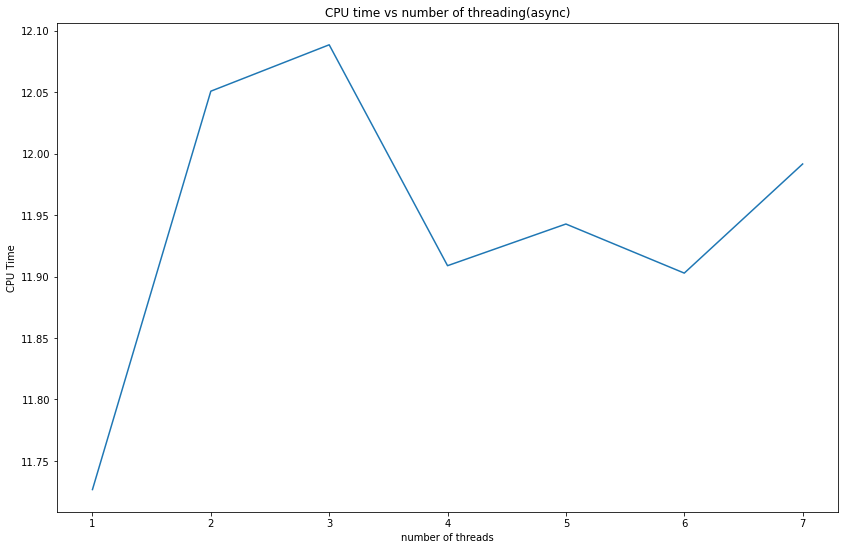

In [13]:
fig, ax = plt.subplots(figsize =(14, 9))
plt.plot(threads,result_cpu)
plt.xlabel("number of threads")
plt.ylabel("CPU Time")
plt.title("CPU time vs number of threading(async)")
plt.show()

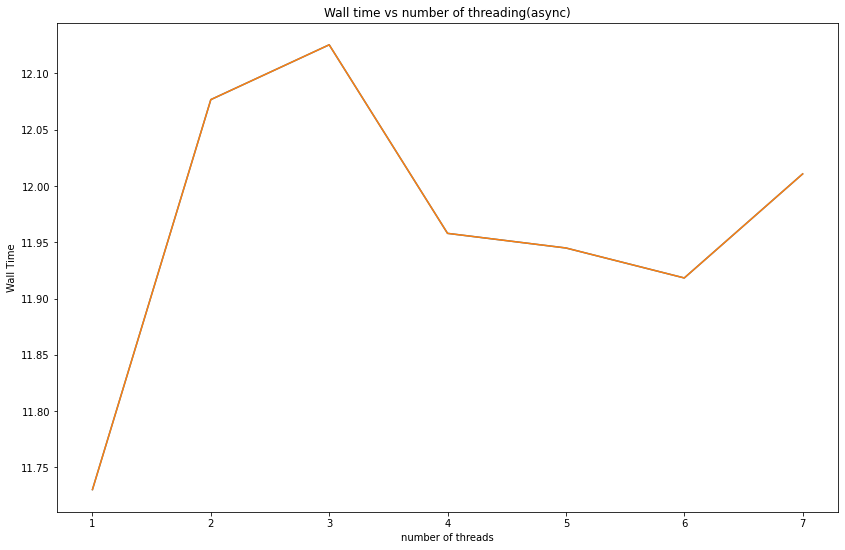

In [14]:
fig, ax = plt.subplots(figsize =(14, 9))
plt.plot(threads,result_wall)
plt.xlabel("number of threads")
plt.ylabel("Wall Time")
plt.plot(threads,result_wall)
plt.title("Wall time vs number of threading(async)")
plt.show()

Based on these plots for each of the methods, we can conclude that cpu time and wall time are very similar across the threads in asyncio case. Now, let us look at the memory usage for some threads

In [15]:
%load_ext memory_profiler

In [18]:
for n in range(1,8):
    %memit thread_par(data,n,df_func)

peak memory: 1873.10 MiB, increment: 916.43 MiB
peak memory: 1869.79 MiB, increment: 913.12 MiB
peak memory: 1866.22 MiB, increment: 909.55 MiB
peak memory: 1862.37 MiB, increment: 905.71 MiB
peak memory: 1874.73 MiB, increment: 918.07 MiB
peak memory: 1856.43 MiB, increment: 899.77 MiB
peak memory: 1875.01 MiB, increment: 918.34 MiB


The memory usage is similar to the iterative case and is quite high in compared to the multiprocessing method. Now,l

### Threading(Pre-Emptive)

In [22]:
def thread_par_nor(df,n,func):
    pool=ThreadPool(processes=n)
    result=pool.apply(func,args=(df,))
    return result

In [23]:
from multiprocessing.pool import ThreadPool
threads=list(range(1,8))
result_cpu=[]
result_wall=[]
for n in threads:
    thre_start_wall=time.perf_counter()
    thre_start_cpu=time.process_time()
    pool=ThreadPool(processes=n)
    result=thread_par_nor(data,n,df_func)
    thre_end_wall=time.perf_counter()
    thre_end_cpu=time.process_time()
    print('>Walltime thread=%d: %.3f seconds' % (n, thre_end_wall-thre_start_wall))
    print('>CPUtime thread=%d: %.3f seconds' % (n, thre_end_cpu-thre_start_cpu))
    result_wall.append(thre_end_wall-thre_start_wall)
    result_cpu.append(thre_end_cpu-thre_start_cpu)

>Walltime thread=1: 12.087 seconds
>CPUtime thread=1: 12.079 seconds
>Walltime thread=2: 12.222 seconds
>CPUtime thread=2: 12.158 seconds
>Walltime thread=3: 12.218 seconds
>CPUtime thread=3: 12.199 seconds
>Walltime thread=4: 12.007 seconds
>CPUtime thread=4: 12.002 seconds
>Walltime thread=5: 12.055 seconds
>CPUtime thread=5: 12.039 seconds
>Walltime thread=6: 12.630 seconds
>CPUtime thread=6: 12.563 seconds
>Walltime thread=7: 12.130 seconds
>CPUtime thread=7: 12.124 seconds


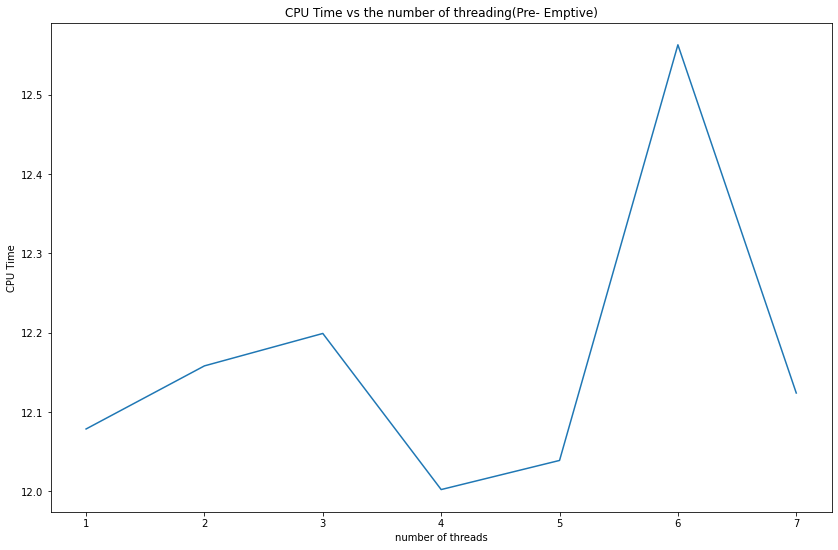

In [24]:
fig, ax = plt.subplots(figsize =(14, 9))
plt.plot(threads,result_cpu)
plt.xlabel("number of threads")
plt.ylabel("CPU Time")
plt.title("CPU Time vs the number of threading(Pre- Emptive)")
plt.show()

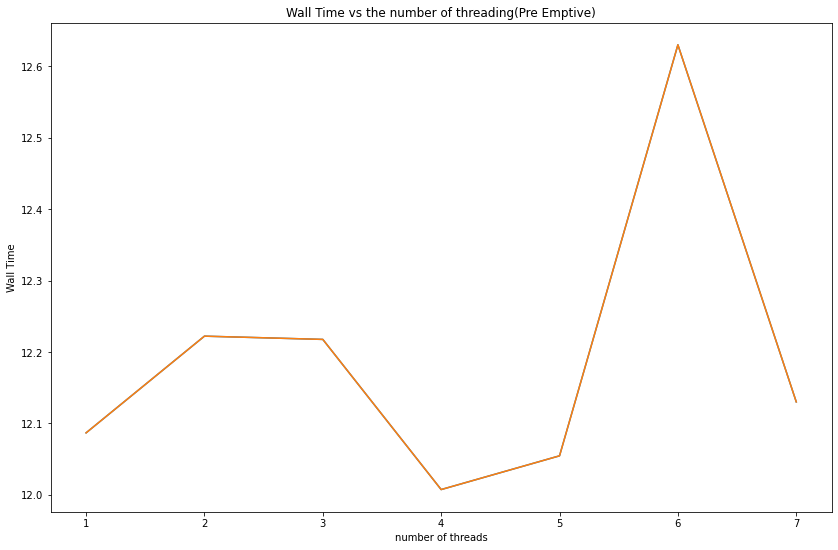

In [25]:
fig, ax = plt.subplots(figsize =(14, 9))
plt.plot(threads,result_wall)
plt.xlabel("number of threads")
plt.ylabel("Wall Time")
plt.plot(threads,result_wall)
plt.title("Wall Time vs the number of threading(Pre Emptive)")
plt.show()

Both CPU and wall time are quite similar to the asyncio method. Now let us look at the memory usage

In [26]:
for n in range(1,8):
    %memit thread_par_nor(data,n,df_func)

peak memory: 1975.50 MiB, increment: 916.25 MiB
peak memory: 1961.03 MiB, increment: 901.71 MiB
peak memory: 1959.75 MiB, increment: 900.45 MiB
peak memory: 1972.63 MiB, increment: 913.32 MiB
peak memory: 1961.55 MiB, increment: 902.25 MiB
peak memory: 1971.64 MiB, increment: 912.33 MiB
peak memory: 1955.63 MiB, increment: 896.32 MiB


Again, the memory usage is similar to the iterative and asyncio method and quite high compared to the multiprocessing method

Now, by htop user in terminal, we can see the cpu usage is varied and not always at 100 percent

### Concurrent Futures

In [27]:
import concurrent.futures

def concurrent_func(func,df,threads):
    with concurrent.futures.ThreadPoolExecutor(max_workers=threads) as tpe:
        results=tpe.submit(func,df)
        print(results.result())
    

In [28]:
from multiprocessing.pool import ThreadPool
threads=list(range(1,8))
result_cpu=[]
result_wall=[]
for n in threads:
    thre_start_wall=time.perf_counter()
    thre_start_cpu=time.process_time()
    async_result=concurrent_func(df_func,data,n)
    thre_end_wall=time.perf_counter()
    thre_end_cpu=time.process_time()
    print('>Walltime thread=%d: %.3f seconds' % (n, thre_end_wall-thre_start_wall))
    print('>CPUtime thread=%d: %.3f seconds' % (n, thre_end_cpu-thre_start_cpu))
    result_wall.append(thre_end_wall-thre_start_wall)
    result_cpu.append(thre_end_cpu-thre_start_cpu)

1719917227.0
>Walltime thread=1: 12.044 seconds
>CPUtime thread=1: 12.032 seconds
1719917227.0
>Walltime thread=2: 12.226 seconds
>CPUtime thread=2: 12.188 seconds
1719917227.0
>Walltime thread=3: 12.084 seconds
>CPUtime thread=3: 12.071 seconds
1719917227.0
>Walltime thread=4: 12.204 seconds
>CPUtime thread=4: 12.156 seconds
1719917227.0
>Walltime thread=5: 12.027 seconds
>CPUtime thread=5: 12.023 seconds
1719917227.0
>Walltime thread=6: 12.038 seconds
>CPUtime thread=6: 12.031 seconds
1719917227.0
>Walltime thread=7: 12.242 seconds
>CPUtime thread=7: 12.213 seconds


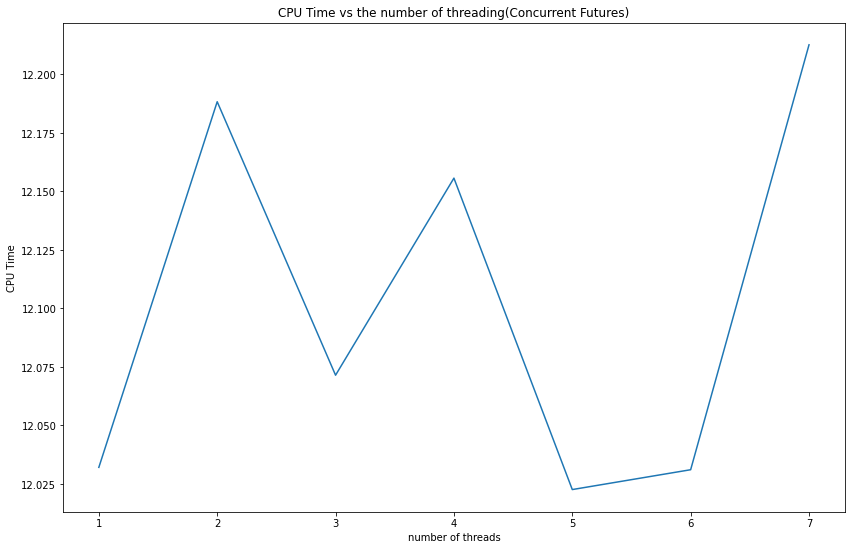

In [29]:
fig, ax = plt.subplots(figsize =(14, 9))
plt.plot(threads,result_cpu)
plt.xlabel("number of threads")
plt.ylabel("CPU Time")
plt.title("CPU Time vs the number of threading(Concurrent Futures)")
plt.show()

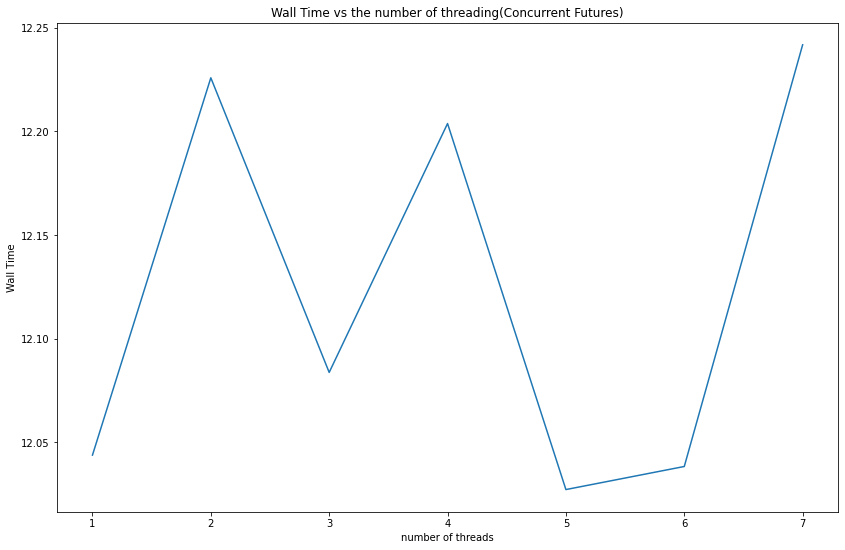

In [30]:
fig, ax = plt.subplots(figsize =(14, 9))
plt.plot(threads,result_wall)
plt.xlabel("number of threads")
plt.ylabel("Wall Time")
plt.title("Wall Time vs the number of threading(Concurrent Futures)")
plt.show()

The CPU and Wall Time are similar to the threading methods above. So, the only difference factor may be the memory usage

In [31]:
for n in range(1,8):
    %memit concurrent_func(df_func,data,n)

1719917227.0
peak memory: 1961.70 MiB, increment: 899.06 MiB
1719917227.0
peak memory: 1966.92 MiB, increment: 904.28 MiB
1719917227.0
peak memory: 1971.82 MiB, increment: 909.18 MiB
1719917227.0
peak memory: 1974.66 MiB, increment: 912.02 MiB
1719917227.0
peak memory: 1961.77 MiB, increment: 899.13 MiB
1719917227.0
peak memory: 1972.60 MiB, increment: 909.96 MiB
1719917227.0
peak memory: 1964.35 MiB, increment: 901.71 MiB


The memory usage is similar to the iterative and threading methods above and is quite high compared to the multiprocessing method

### Subprocess

In [111]:
import summation

1719917227.0


In [81]:
import os
os.chdir("/home/ahnaf.ryan/datascience work/sask_ndti_analysis/sask_ndti_analysis/src/data")

We call the function sum.py to run in a subprocess and account for the cpu and wall time. We then proceed to calculate the memory usage

1716142355.0
0
17.13455094001256
0.0155086999999412


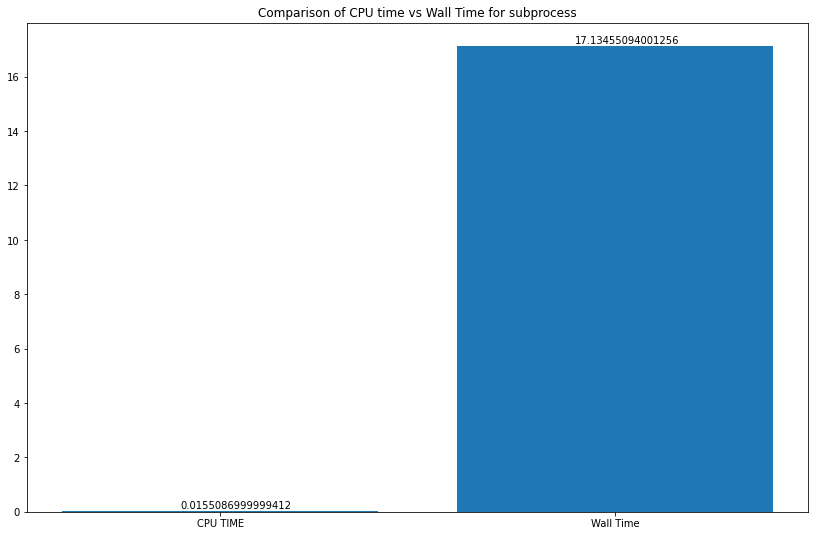

In [87]:
def run_sub():
    sub_start_wall_two_core=time.perf_counter()
    sub_start_cpu_two_core=time.process_time()
    p=subprocess.run('python summation.py',shell=True)
    print(p.returncode)
    sub_end_wall_two_core=time.perf_counter()
    sub_end_cpu_two_core=time.process_time()
    print(sub_end_wall_two_core-sub_start_wall_two_core)
    print(sub_end_cpu_two_core-sub_start_cpu_two_core)
    sub_cpu_time=sub_end_cpu_two_core-sub_start_cpu_two_core
    sub_wall_time= sub_end_wall_two_core-sub_start_wall_two_core
    return sub_cpu_time,sub_wall_time
sub_cpu_time,sub_wall_time=run_sub()
x_val=["CPU TIME","Wall Time"]
y=[sub_cpu_time,sub_wall_time]
fig, ax = plt.subplots(figsize =(14, 9))
plt.bar(height=y,x=x_val)
ax.set_title("Comparison of CPU time vs Wall Time for subprocess")
plt.text(-0.1, y[0]+0.1, str(y[0]))
plt.text(0.9, y[1]+0.1, str(y[1]))
plt.show(block=False)
    

The Cpu time is the lowest we have ever seen and on the contrary wall time is the highest we have ever seen.

In [88]:
%memit run_sub()

1720087714.0
0
14.865563979139552
0.013896100000010847
peak memory: 1171.06 MiB, increment: 0.00 MiB


The peak memory is lower than all the methods except for multiprocessing however astonishingly increment memory is 0 which may be a bug or 0 due to the fact that we are technically running a different script. 

## Bottlenecks

Earlier, we noticed that even though cpu computation time in multiprocessing was extremely low, wall time was surprisingly high. Let us investigate what might have happened

In [32]:
%lprun -f get_data get_data(data,df_func)

Timer unit: 1e-06 s

Total time: 23.7519 s
File: /tmp/ipykernel_1413811/4149737121.py
Function: get_data at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def get_data(df,func,n_split=1000,n_core=2):
     2         1     323394.0 323394.0      1.4      df_split=np.array_split(df,n_split)
     3         1      32591.0  32591.0      0.1      pool=Pool(n_core)
     4         1   23366418.0 23366418.0     98.4      df=sum(pool.map(func,df_split))
     5         1        101.0    101.0      0.0      pool.close()
     6         1      29371.0  29371.0      0.1      pool.join()
     7         1          3.0      3.0      0.0      return df

In [33]:
%lprun -f df_func df_func(data)

Timer unit: 1e-06 s

Total time: 23.7579 s
File: /tmp/ipykernel_1413811/865498790.py
Function: df_func at line 15

Line #      Hits         Time  Per Hit   % Time  Line Contents
    15                                           def df_func(df):
    16         1      49578.0  49578.0      0.2      value=df["PSECT"]*df["PMER"]
    17         1      34647.0  34647.0      0.1      value=round(value,ndigits=None)
    18         1   23655227.0 23655227.0     99.6      value=value.apply(func=if_prime)
    19         1      18416.0  18416.0      0.1      return value.sum()

As you can see, most of the cpu usage has been in the iteration of the prime functions. Moreover, in terminal when htop has been ran, we can see 100% of two CPU is run in the parallel process. So, the bottleneck should be in the part of the code and since cpu time is extremely low, it must be the case importing the data and running the cell creates the bottleneck.

## Which is the best solution?

In terms of wall time, all of them performed similarly however in terms of CPU time, multiprocessing performed significantly better. Moreover, memory usage was almost 4 times smaller than all the other methods provided. So we can conclude that the multiprocessing method performed best.

## Conclusion Assumptions

Our conclusion assumptions rely on the fact that most of the percent of the cpu usage was in the iteration of the prime function. However, in different cases that involves I/O processes, the conclusion may be different. However, in cpu heavy processes, we can conclude that multiprocessing will perform best.